In [41]:
# import the necessary packages
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import os
import matplotlib.pyplot as plt

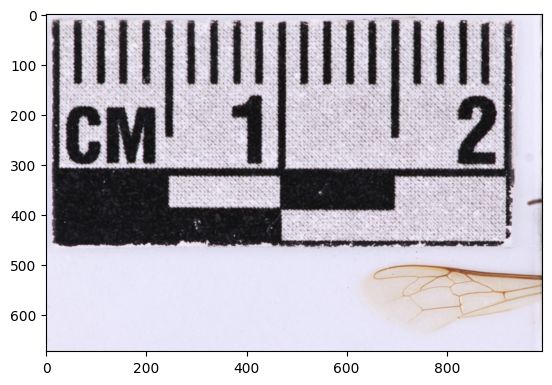

In [42]:
# read in test image
image_path = "/Users/dannahgolich/Desktop/example/example.jpg"
image = cv2.imread(image_path)
plt.imshow(image[:,:,::-1])

#image = cv2.pyrDown(image)

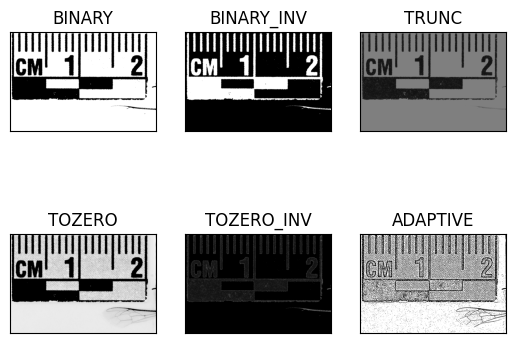

In [43]:
# thresholding options
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
ret,thresh1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(img,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(img,127,255,cv2.THRESH_TOZERO_INV)
adapt_thresh = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
titles = ['BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV',"ADAPTIVE"]
images = [thresh1, thresh2, thresh3, thresh4, thresh5, adapt_thresh]
for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray',vmin=0,vmax=255)
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


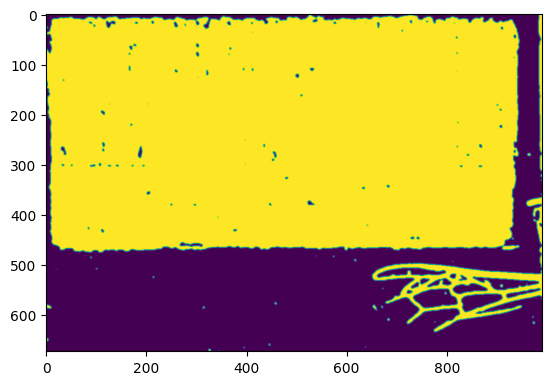

In [44]:
# try to identify ruler with adaptive threshold image
# blur multiple times
adapt_thresh = cv2.GaussianBlur(adapt_thresh, (7, 7), 0)
adapt_thresh = cv2.GaussianBlur(adapt_thresh, (7, 7), 0)
adapt_thresh = cv2.GaussianBlur(adapt_thresh, (7, 7), 0)
adapt_thresh = cv2.GaussianBlur(adapt_thresh, (7, 7), 0)
adapt_thresh = cv2.GaussianBlur(adapt_thresh, (7, 7), 0)
# binary inverted
ret, adapt_thresh_binary = cv2.threshold(adapt_thresh, 210, 255, cv2.THRESH_BINARY_INV)
# blur again
adapt_thresh_binary = cv2.GaussianBlur(adapt_thresh_binary, (5, 5), 0)
plt.imshow(adapt_thresh_binary)

In [45]:
# need two largest contours
cnts = cv2.findContours(adapt_thresh_binary.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
max_contour = cv2.contourArea(max(cnts, key=cv2.contourArea))
print(f'max contour: {max_contour}')
print(f'min contour: {cv2.contourArea(min(cnts, key=cv2.contourArea))}')
print(f'length of contours: {len(cnts)}\n')
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
cnts = cnts[:2] # only want two largest
area_list = []
pixels_per_cm = None # should be number of pixels for ruler cnt / 2
for c in cnts:
    area = cv2.contourArea(c)
    area_list += [area]
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    orig = image.copy()
    # compute the rotated bounding box of the contour
    box = cv2.minAreaRect(c)
    box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
    box = np.array(box, dtype="int")
    # order the points in the contour such that they appear
    # in top-left, top-right, bottom-right, and bottom-left
    # order, then draw the outline of the rotated bounding
    # box
    cv2.drawContours(orig, [box.astype("int")], -1, (0, 255, 0), 2)
    length = extRight[0] - extLeft[0]
    if pixels_per_cm is None:
        pixels_per_cm = length / 2
        print(f"Ruler object pixel length: {length}")
        type = 'ruler'
    else:
        print(f"wing pixel length: {length}")
        type = 'wing'
    print(f"length in cm: {length / pixels_per_cm}")
    cv2.imwrite(f'object_with_contours_{type}.jpg', orig)
print(area_list)

max contour: 433457.5
min contour: 8.0
length of contours: 30

Ruler object pixel length: 947
length in cm: 2.0
wing pixel length: 340
length in cm: 0.7180570221752904
[433457.5, 27987.5]
